In [1]:
import functions as fn
import numpy as np; import matplotlib.pyplot as  plt; import pandas as pd
from sklearn.covariance import LedoitWolf as lw
from sklearn.preprocessing import scale
from scipy.spatial.distance import mahalanobis as mhl
%matplotlib inline

# Filtrado de datos atípicos
## Características del filtrado de outliers
Para el filtrado de outliers se toma como base el volúmen y el rendimiento obtenidos a partit de la serie de datos del NASDAQ.

In [2]:
plt.rcParams.update({'font.size': 11})
serie_price_original = pd.read_csv('datos.csv')
serie_price = serie_price_original.copy()
serie_price_original = serie_price_original[1:]
vol_escalado = scale(X=serie_price['Volume'], axis=0, with_mean=True, with_std=True) 
serie_price['Volume_est'] = vol_escalado
serie_price['rdto'] = (serie_price['Close'] / serie_price['Close'].shift(1) - 1) * 100 #Base 100
# serie_price['rdto'] = serie_price['rdto'] - np.mean(serie_price['rdto'])
serie_limpia = serie_price[['Volume_est', 'rdto']][1:]
serie_limpia.reset_index(drop = True)
serie_price_original['rdto'] = serie_price['rdto']
serie_price_original.reset_index(drop = True)

c:\Users\camil\Documents\PYTHON\py-dev\lib\site-packages\sklearn\preprocessing\_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


,Date,Open,High,Low,Close,Adj Close,Volume,rdto
0,2014-09-03,4610.140137,4610.140137,4565.379883,4572.560059,4572.560059,1897450000,-0.557391
1,2014-09-04,4581.520020,4603.149902,4553.310059,4562.290039,4562.290039,1728700000,-0.224601
2,2014-09-05,4560.629883,4583.000000,4542.740234,4582.899902,4582.899902,1641830000,0.451744
3,2014-09-08,4579.060059,4600.399902,4570.229980,4592.290039,4592.290039,1670210000,0.204895
4,2014-09-09,4588.830078,4599.029785,4544.439941,4552.290039,4552.290039,1956550000,-0.871025
...,...,...,...,...,...,...,...,...
1336,2019-12-23,8950.200195,8956.639648,8934.549805,8945.650391,8945.650391,2025450000,0.231827
1337,2019-12-24,8955.009766,8957.120117,8934.360352,8952.879883,8952.879883,1014520000,0.080816
1338,2019-12-26,8970.209961,9022.459961,8968.459961,9022.389648,9022.389648,1634920000,0.776396
1339,2019-12-27,9049.469727,9052.000000,8987.320313,9006.620117,9006.620117,1832200000,-0.174782


<h1 style=""><b> Análisis de componentes principales PCA</b></h1>
<h2 style=""><b> Centrado de datos</b></h2>
Debido a que el PCA supone una distribución gaussiana o normal de los datos, es pertinente realizar el centrado de los mismos. Para ello, se utiliza la matriz $P$ como sigue:

\begin{equation*}
    P_n = I_n - \frac{ones(n)}{n} 
\end{equation*}

Con lo cual, los datos $D$ centrados quedarían como sigue:

\begin{equation*}
    D_{Centrados} = P_n * D
\end{equation*}

In [3]:
#%% Se define la matriz de centrado como:
p = np.identity(len(serie_limpia)) - np.ones(len(serie_limpia))/len(serie_limpia)

print('Media', np.mean(np.mean(serie_limpia)))
print('Varianza', np.var(np.var(serie_limpia)))

d_centrados = np.dot(p ,serie_limpia)

print('')
print('Varianza y media de datos centrados:')
print('Media', np.mean(d_centrados))
print('Varianza', np.std(np.var(d_centrados)))


Media 0.027547193302463604
Varianza 0.00024342708514912917

Varianza y media de datos centrados:
Media -4.238882838240717e-17
Varianza 0.0


c:\Users\camil\Documents\PYTHON\py-dev\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


<h2 style=""><b> Estimación de la matriz de covarianza</b></h2>

Para estimar la matriz de covarianza se hace uso del estimador bien condicionado para matrices de covarianza de Ledoit y Wolf. Por medio de esta, se mejora la estimación de la matriz de covarianza de los datos. Como se muestra a continuación, el número de condición de la matriz de covarianza estimada con Ledoit y Wolf, es ligeramente menor que la estimada convencionalmente.

In [4]:
sigma = lw().fit(serie_limpia).covariance_

<h2 style=""><b> Descomposición en valores singulares de la matriz de covarianza</b></h2>

In [5]:
eigenval, eigenvec = np.linalg.eig(sigma)
pca = eigenval/sum(eigenval)
pca*100

array([43.64302447, 56.35697553])

<h1 style=""><b> Aplicación de la métrica de Mahalanobis para filtrado de outliers</b></h1>

In [6]:
#filtrado de outliers con la distancia de Mahalanobis.
# cv = 0 --> Estimación Ledoit Wolf
# cv = 1 --> Estimación convencional
mahal_serie_limpia = fn.outliers(serie_limpia, lam = 1.75, cv = 1)
# mahal_serie_limpia = fn.outliers(serie_limpia, lam = 1.75, cv = 0)

Condición  1.3998393545395145


# Análisis del número de condición y del determinante de la matriz de covarianza
## Invertibilidad
Se percibe que la invertibilidad de la matriz de covariaza mejora al sumarle lambda veces la identidad. Esto se ve reflejado con la disminución del número de condición y el incremento del determinante a medida que aumenta el valor de lambda. Para este caso se selecciona un lambda que varía entre 0 y 2. La matriz de covarianza original sin el encogimiento, ya presenta un número de condición pertinente para continuar con el análsis. Sin embargo, se selecciona un lambda con un valor de 1.75, y que con este encogimiento la matriz de covarianza mejora notablemente su invertibilidad (ver la siguiente figura). Esto con la intención de mejorar los resultados del filtrado de outliers con la distancia de Mahalanobis, la cual incluye la inversa de la matriz de covarianza.

Para el caso de la inversa, esta se desarrolla con la inversa generalizada de la matriz de covarianza, siguiendo la expresión matemática a continuación:

\begin{equation*}
A^{-1} = A^T (AA^T)^{-1},
\end{equation*}

donde $A$ representa la matriz de covarianza.

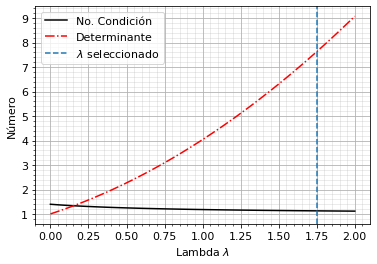

In [7]:
t = np.linspace(0,2,50)

condi = []
date = []

for i in range(len(t)):
    [s, c, d] = fn.cov1(serie_limpia, t[i])
    condi.append(c)
    date.append(d)

plt.figure()
plt.minorticks_on(); plt.grid(which='major', zorder = -10); plt.grid(which='minor', alpha = 0.3, zorder = -10)
plt.plot(t, condi, 'k')
plt.plot(t, date, 'r-.')
plt.axvline(1.75, linestyle = '--')
plt.xlabel('Lambda $\lambda$'); plt.ylabel('Número'); plt.legend(['No. Condición', 'Determinante', '$\lambda$ seleccionado'])
plt.savefig('img/cond.png', bbox_inches='tight', dpi=300)

<h1 style=""><b> Resultado del filtrado de outliers</b></h1>
En la siguiente figura se puede evidenciar los datos atipicos que fueron detectados por el algoritmo con las características definidas anteriormente. En la subfigura de la izquierda se encuentran los datos sin aplicar la detección de ourliers y en la figura de la derecha se encuentran los datos atípicos removidos por el algoritmo con la distancia de Mahalanobis.

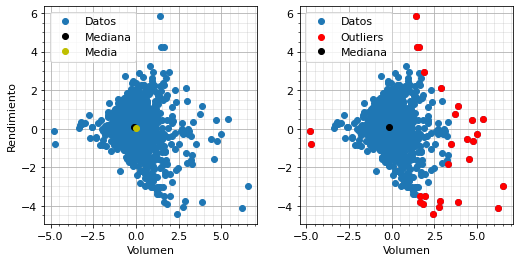

In [12]:
limit = np.percentile(mahal_serie_limpia, 98)
outliers_datos = serie_limpia[mahal_serie_limpia > limit]
datos_limpios = serie_limpia[mahal_serie_limpia < limit]

plt.figure(figsize=(8.4,4))
plt.subplot(1,2,1)
plt.scatter(serie_limpia['Volume_est'], serie_limpia['rdto'], zorder = 10)
plt.plot(np.median(serie_limpia['Volume_est']), np.median(serie_limpia['rdto']), 'ko', zorder=10)
plt.plot(np.mean(serie_limpia['Volume_est']), np.mean(serie_limpia['rdto']), 'yo', zorder=10)
plt.xlabel('Volumen'); plt.ylabel('Rendimiento')
plt.minorticks_on(); plt.grid(which='major', zorder=0); plt.grid(which='minor', alpha=0.3)
plt.legend(['Datos', 'Mediana', 'Media'], loc = 'upper left')

plt.subplot(1,2,2)
plt.scatter(serie_limpia['Volume_est'], serie_limpia['rdto'], zorder=10)
plt.scatter(outliers_datos['Volume_est'], outliers_datos['rdto'], c = 'r', zorder=10)
plt.plot(np.median(serie_limpia['Volume_est']), np.median(serie_limpia['rdto']), 'ko', zorder=10)
plt.xlabel('Volumen')
plt.minorticks_on(); plt.grid(which='major', zorder=0); plt.grid(which='minor', alpha=0.3)

plt.legend(['Datos', 'Outliers', 'Mediana'], loc = 'upper left')

plt.savefig('img/mediana.png',bbox_inches='tight', dpi=300)


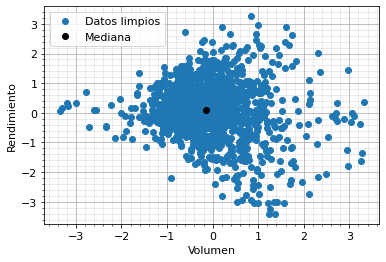

In [9]:
plt.figure()
plt.scatter(datos_limpios['Volume_est'], datos_limpios['rdto'], zorder=10)
plt.plot(np.median(serie_limpia['Volume_est']), np.median(serie_limpia['rdto']), 'ko', zorder=10)
plt.xlabel('Volumen'); plt.ylabel('Rendimiento')
plt.minorticks_on(); plt.grid(which='major', zorder=0); plt.grid(which='minor', alpha=0.3)

plt.legend(['Datos limpios', 'Mediana'], loc = 'upper left')

plt.savefig('img/datosLimpios.png',bbox_inches='tight', dpi=300)


En la subfigura izquiera de la figura anterior, se evidencia la diferencia entre la mediana y la media. En ella, la media se ve afectada por los datos que tienden a alejarse por el lado derecho, así que la media está más a la derecha que la mediana. Por el contrario, la mediana se mantiene en su sitio a pesar de los datos atípicos. Por ello, para la distancia de Mahalanobis se hace uso de la mediana, con lo cual se obtiene un método robusto de filtrado de outliers.

In [10]:
dataset_limpio = serie_price_original[mahal_serie_limpia < limit]
dataset_limpio = dataset_limpio.reset_index(drop = True)

positive_treshold = 0.000000001
negative_treshold = -0.000000001

dataset_limpio['rdto_5D'] = (dataset_limpio['Close'] / dataset_limpio['Close'].shift(5) - 1) * 100
dataset_limpio['rdto_10D'] = (dataset_limpio['Close'] / dataset_limpio['Close'].shift(10) - 1) * 100
dataset_limpio['rdto_30D'] = (dataset_limpio['Close'] / dataset_limpio['Close'].shift(30) - 1) * 100
dataset_limpio['rdto_90D'] = (dataset_limpio['Close'] / dataset_limpio['Close'].shift(90) - 1) * 100

def mean_vol_ventana(df_volume, dias):
  mean_volume = ['nan'] * (dias) 
  tb_vol_i = ['nan'] * (dias) 
#   print(len(df_volume))
  for i in range (dias, len(df_volume)):
    mean_volume_i = np.mean(df_volume[i-dias:i])
    mean_volume.append(mean_volume_i) 
    condition = (df_volume[i]/mean_volume_i) - 1
    if condition > positive_treshold:
      tb_vol_i.append(1)
    else:
      tb_vol_i.append(0)
  return pd.DataFrame(tb_vol_i)

dataset_limpio['volume_5D'] = mean_vol_ventana(dataset_limpio['Volume'],5)
dataset_limpio['volume_10D'] = mean_vol_ventana(dataset_limpio['Volume'],10)
dataset_limpio['volume_30D'] = mean_vol_ventana(dataset_limpio['Volume'],30)
dataset_limpio['volume_90D'] = mean_vol_ventana(dataset_limpio['Volume'],90)

dataset_limpio = dataset_limpio[:][90:]

dataset_limpio['t_rdto_1D'] = dataset_limpio.apply(lambda row: 1 if row['rdto']>positive_treshold else (0 if row['rdto']<negative_treshold else 0),axis=1)
dataset_limpio['t_rdto_5D'] = dataset_limpio.apply(lambda row: 1 if row['rdto_5D']>positive_treshold else (0 if row['rdto_5D']<negative_treshold else 0),axis=1)
dataset_limpio['t_rdto_10D'] = dataset_limpio.apply(lambda row: 1 if row['rdto_10D']>positive_treshold else (0 if row['rdto_10D']<negative_treshold else 0),axis=1)
dataset_limpio['t_rdto_30D'] = dataset_limpio.apply(lambda row: 1 if row['rdto_30D']>positive_treshold else (0 if row['rdto_30D']<negative_treshold else 0),axis=1)
dataset_limpio['t_rdto_90D'] = dataset_limpio.apply(lambda row: 1 if row['rdto_90D']>positive_treshold else (0 if row['rdto_90D']<negative_treshold else 0),axis=1)

dataset_limpio = dataset_limpio.drop(['rdto_5D', 'rdto_10D', 'rdto_30D', 'rdto_90D'], axis=1)
dataset_limpio = dataset_limpio.reset_index(drop = True)

dataset_limpio.set_index('Date', inplace = True)

dataset_limpio.to_csv('dataset_limpio_98.csv')

dataset_limpio

,Open,High,Low,Close,Adj Close,Volume,rdto,volume_5D,volume_10D,volume_30D,volume_90D,t_rdto_1D,t_rdto_5D,t_rdto_10D,t_rdto_30D,t_rdto_90D
Date,,,,,,,,,,,,,,,,
2015-01-12,4714.069824,4715.810059,4650.649902,4664.709961,4664.709961,1861960000,-0.836719,0,1,1,0,0,1,0,0,1
2015-01-13,4708.740234,4751.339844,4624.279785,4661.500000,4661.500000,2162180000,-0.068814,1,1,1,1,0,1,0,0,1
2015-01-14,4610.759766,4655.370117,4595.979980,4639.319824,4639.319824,2073810000,-0.475816,1,1,1,1,0,0,0,0,1
2015-01-15,4657.459961,4663.959961,4567.390137,4570.819824,4570.819824,1976260000,-1.476510,0,1,1,1,0,0,0,0,0
2015-01-16,4566.379883,4635.819824,4563.109863,4634.379883,4634.379883,1970520000,1.390561,1,1,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,8950.200195,8956.639648,8934.549805,8945.650391,8945.650391,2025450000,0.231827,0,0,0,1,1,1,1,1,1
2019-12-24,8955.009766,8957.120117,8934.360352,8952.879883,8952.879883,1014520000,0.080816,0,0,0,0,1,1,1,1,1
2019-12-26,8970.209961,9022.459961,8968.459961,9022.389648,9022.389648,1634920000,0.776396,0,0,0,0,1,1,1,1,1
